## FORMULA 1 PROJECT- Hyperparameter Tuning

In [1]:
%run F1_functions.ipynb

/Users/dianaow/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [344]:
train_set = read_from_pickle(directory, "train_set.pickle")
test_set = read_from_pickle(directory, "test_set.pickle")

In [345]:
dataset = pd.concat([train_set, test_set])

In [5]:
# Standardize variables 
njobs = 4
rs=12

index_list = ['year', 'name', 'driverRef']
target_var_list = ['statusId']

xl = pd.ExcelFile("/Users/dianaow/Downloads/F1_Tyre_data.xlsx")
xl.sheet_names
pirelli = xl.parse("Sheet7")
races_dict = pirelli[['year', 'name']].to_dict('list')
races = list(train_set.name.unique())
num_of_races = len(races) 

# create a dummy class for no sampling
class NoSampling(object):
    
    def fit_sample(self, X, y):
        return X, y
    
samplers = [
    ['No Sampling', NoSampling()],
    #['Random Oversampler', RandomOverSampler(random_state=rs)],
    #['SMOTE', SMOTE(ratio='minority', k_neighbors=1, random_state=rs)],
    #['SMOTE ENN', SMOTEENN(random_state=rs)]
]

skfold = StratifiedKFold(n_splits=10, random_state=rs, shuffle=True)

## 1b) Use cross-validation to pick the best performing classification method

In [6]:
classifiers = [
    ['Logistic Regression', LogisticRegressionCV(solver='liblinear',\
                                                 penalty='l1', max_iter= 500, Cs=10, cv=5, verbose=1,\
                                                 n_jobs=njobs, random_state=rs, class_weight='balanced')],
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight='balanced')],
    ['KNN', KNeighborsClassifier(n_jobs=njobs, n_neighbors=1)],
    ['SVM (linear kernel)', SVC(kernel = 'linear', probability=True, verbose=1, random_state=rs, class_weight='balanced')],
    ['SVM (rbf kernel)', SVC(kernel = 'rbf', probability=True, verbose=1, random_state=rs, class_weight='balanced')],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', MLPClassifier(random_state=rs)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
    ['Ada Boost', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),random_state=rs,learning_rate=0.1)]
]

clfs_repeated = [classifiers] * 20

In [7]:
#results_binary, pred_binary, pred_binary_train, proba_binary, proba_binary_train = singletarget_PREDICTION_loop(
    
    #train_set, test_set, [2016], [2017], index_list, target_var_list, \
    #'StandardScaler', clfs_repeated, samplers, skfold, races, races_dict, meta_learner="", cross_validate=True
    
#)

In [8]:
#cvmetrics_list = ["CrossValMeans"]
#rbtt = plot_algo_results(results_binary, "Method", cvmetrics_list, 'desc')

### I decided to choose MLP,  RandomForest, ExtraTrees and the GradientBoosting classifiers for hyperparameter tuning.

## 1c) Hyperparameter Tuning

#### Becuase gridsearch is computationally expensive, I will conduct hyperparameter tuning on Google's Datalab instead. The optimal parameters will then be transfered here. To make things less computationally expensive, I narrowed down the races to gridsearch - just 4 out of the 20 races in a seaon. "F1 score" is chosen as the scorer for GridSearchCB because it is the best metric for imbalanced datasets

#### I need to flip the 0 and 1 labels. I have previously encoded the majority class as 1 and the minority class as 0. Since I'm interested in predicting the minority class this skews the report of the evaluation metrics in favor of whatever the majority class is. I have selected only 2 evaluation metrics: F1 score and Average Precision score because they are useful measures of success of prediction when the classes are very imbalanced. 

In [323]:
def grid_search_wrapper_loop(df, df_test, train_yr, test_yr, index_list, target_var_list, 
                             scaler, races_to_use, races_curr_same_cat, races_same_cat, 
                             clf, param_grid, scorer, refit, print_stats=False, plot_params=False
                            ):

    search_results_all = pd.DataFrame()
    
    for name in races_to_use:
        
        train_set, test_set, Xs_train, Xs_test, Y_train, Y_test = \
          build_train_test_set(
                            df, df_test, train_yr, test_yr, 
                            index_list, target_var_list, target_var_list, scaler, 
                            name, races_curr_same_cat, races_same_cat, multilabel=False, print_stats=False)
            
        Y_train_flip = np.logical_not(Y_train).astype(int)
        Y_train_flip = np.array(Y_train_flip).ravel()
        
        if plot_params==True:
            plot_indiv_params(Xs_train, Y_train_flip, clf, param_grid, scorer, refit)
        else:
            search_results = search_all_params(name, Xs_train, Y_train_flip, clf, param_grid, scorer, refit)
            search_results_all = pd.concat([search_results_all, search_results])
            
    return search_results_all

def plot_indiv_params(Xs_train, Y_train_flip, clf, param_grid, scorer, refit):
    
    index = 1
    plt.figure(figsize=(16,12))
    for parameter, param_range in dict.items(param_grid):   
        grid_search = GridSearchCV(clf, param_grid = {parameter: param_range}, scoring=scorer, refit=refit, cv=skfold, return_train_score=True, n_jobs=-1)
        grid_search.fit(Xs_train, Y_train_flip)

        df = {}
        for i, score in enumerate(grid_search.grid_scores_):
            df[score[0][parameter]] = score[1]

        df = pd.DataFrame.from_dict(df, orient='index')
        df.reset_index(level=0, inplace=True)
        df = df.sort_values(by='index')

        plt.subplot(3,2,index)
        plot = plt.plot(df['index'], df[0])
        plt.title(parameter)
        index += 1
    
    return

def search_all_params(name, Xs_train, Y_train_flip, clf, param_grid, scorer, refit):

    grid_search = GridSearchCV(clf, param_grid, scoring=scorer, refit=refit, cv=skfold, return_train_score=True, n_jobs=-1)
    grid_result = grid_search.fit(Xs_train, Y_train_flip)

    search_results = pd.DataFrame(grid_search.grid_scores_)
    search_results['name'] = name
    search_results['scorer'] = scorer
    search_results['classifiers'] = [clone(clf.set_params(**i)) for i in search_results['parameters']]
    search_results['best score'] = grid_search.best_score_
    search_results = search_results.sort_values('mean_validation_score', ascending=False).head(5)

    return search_results

### 1) Random Forest Classifier

#### Plot individual params

In [327]:
RFC = RandomForestClassifier(n_jobs = njobs, random_state =rs, bootstrap=False, criterion="gini", class_weight=None)

rf_param_grid_1 = {"max_depth": np.arange(1, 28, 2),
                  "max_features": range(3,18,2),
                  "min_samples_split": range(2,22,2),
                  "min_samples_leaf": range(2,22,2),
                  "n_estimators" : np.arange(1, 300, 10),
                  }

""


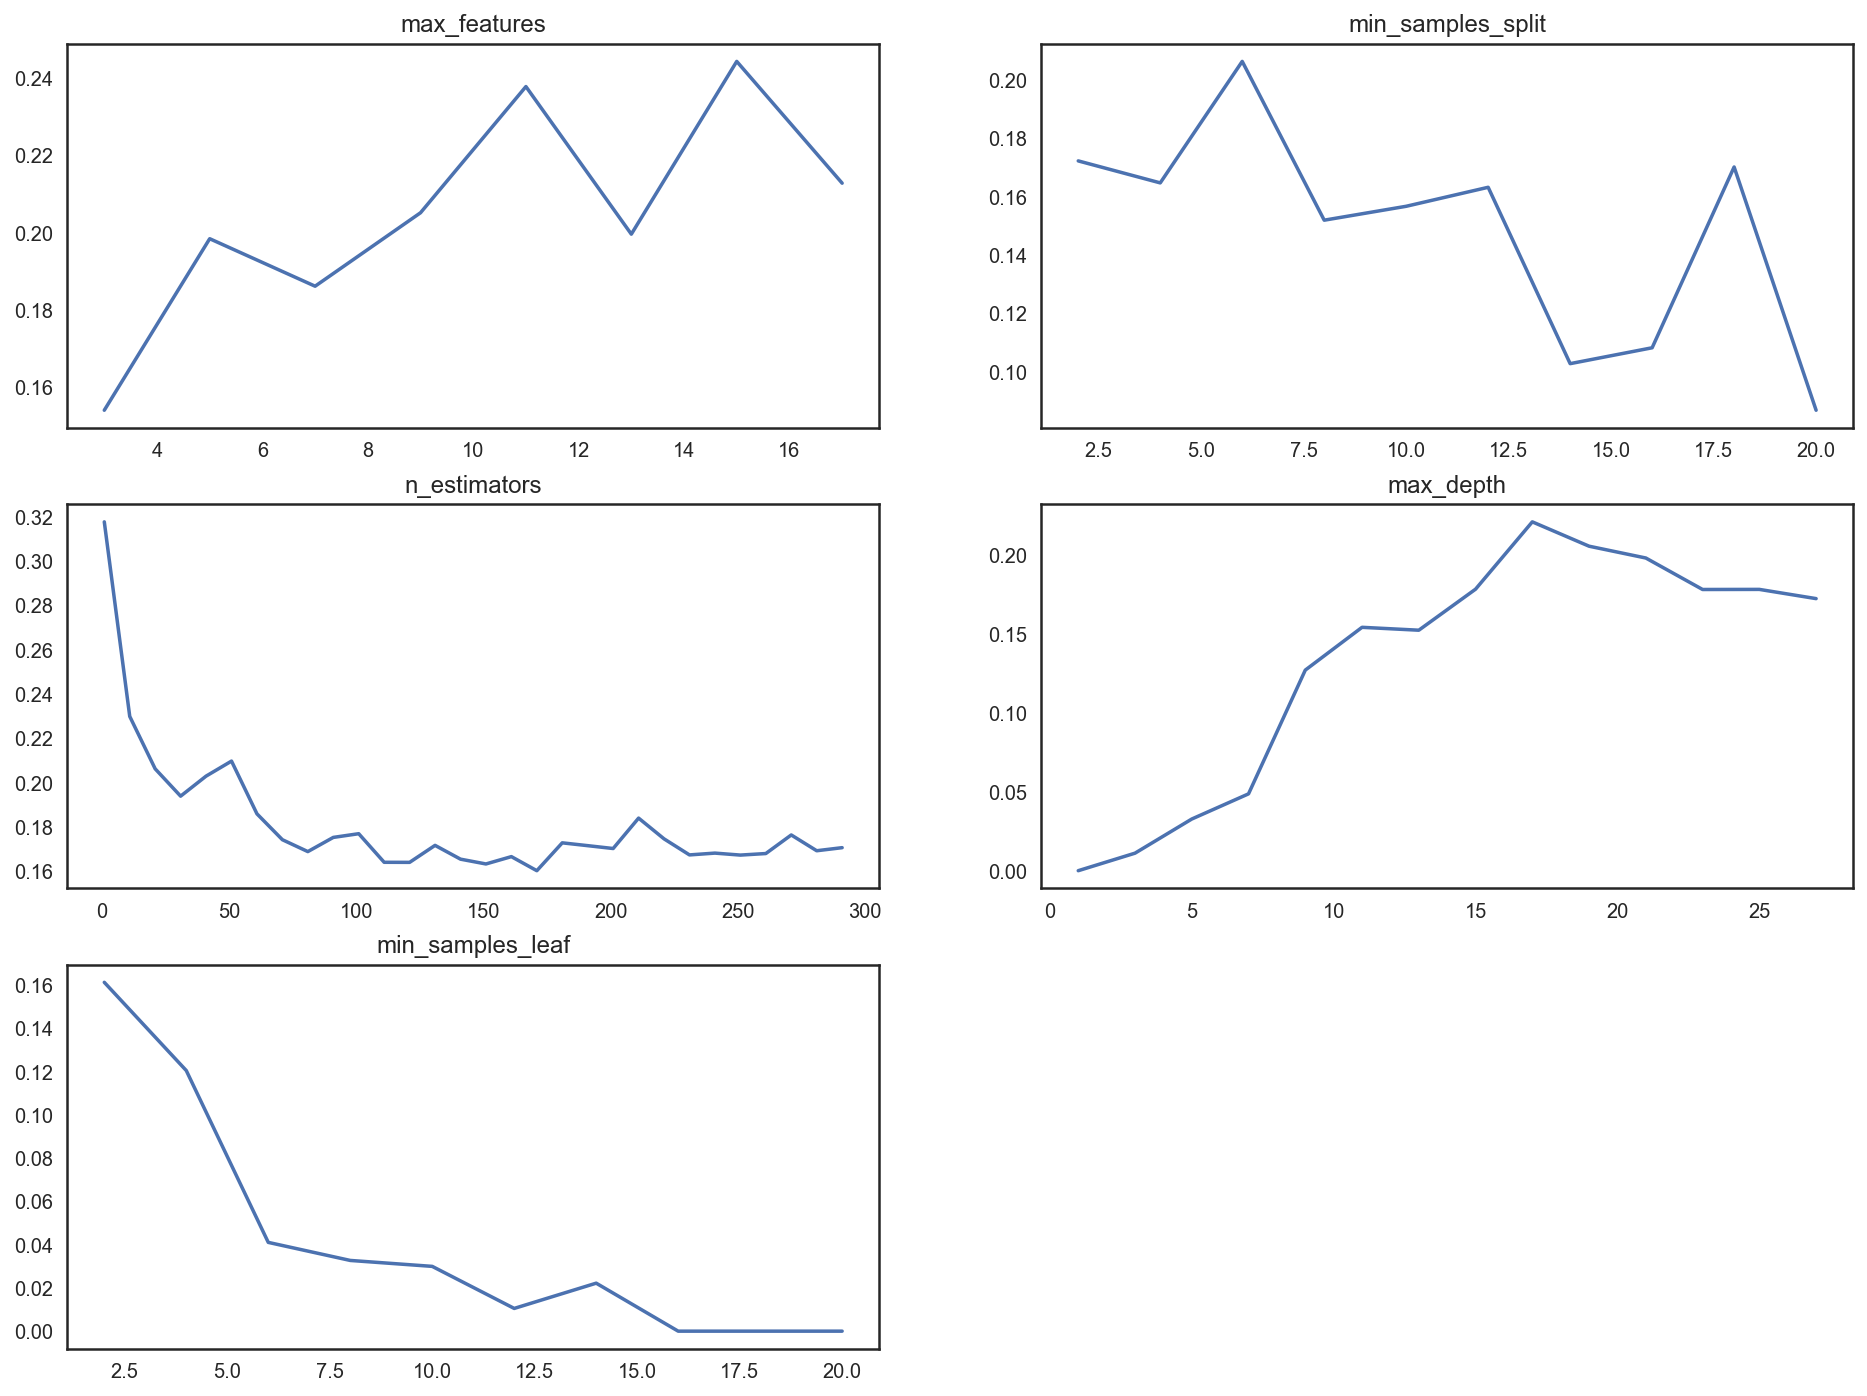

In [328]:
grid_search_wrapper_loop(
    dataset, test_set, [2016], [2017], index_list, target_var_list, 
    'StandardScaler', [races[-1]], races, races_dict, RFC, rf_param_grid_1, scorer='f1', refit=True,
    print_stats=False, plot_params=True
)

#### Param Grid 1

In [347]:
RFC = RandomForestClassifier(n_jobs = njobs, random_state =rs, bootstrap=False, criterion="gini", class_weight=None,
                             min_samples_leaf=2)

rf_param_grid = {
                 "max_depth": [6,8,10],
                 "max_features": [5,10,15],
                 "min_samples_split": [6,12,18],
                 "n_estimators" :[10,50]
                  }

In [348]:
rfc_params = grid_search_wrapper_loop(
    
    dataset, test_set, [2016], [2017], index_list, target_var_list, 'StandardScaler', 
    races, races, races_dict, RFC, rf_param_grid, scorer='f1', refit=True, print_stats=False, plot_params=False
)

### 2) Extra Trees Classifier

""


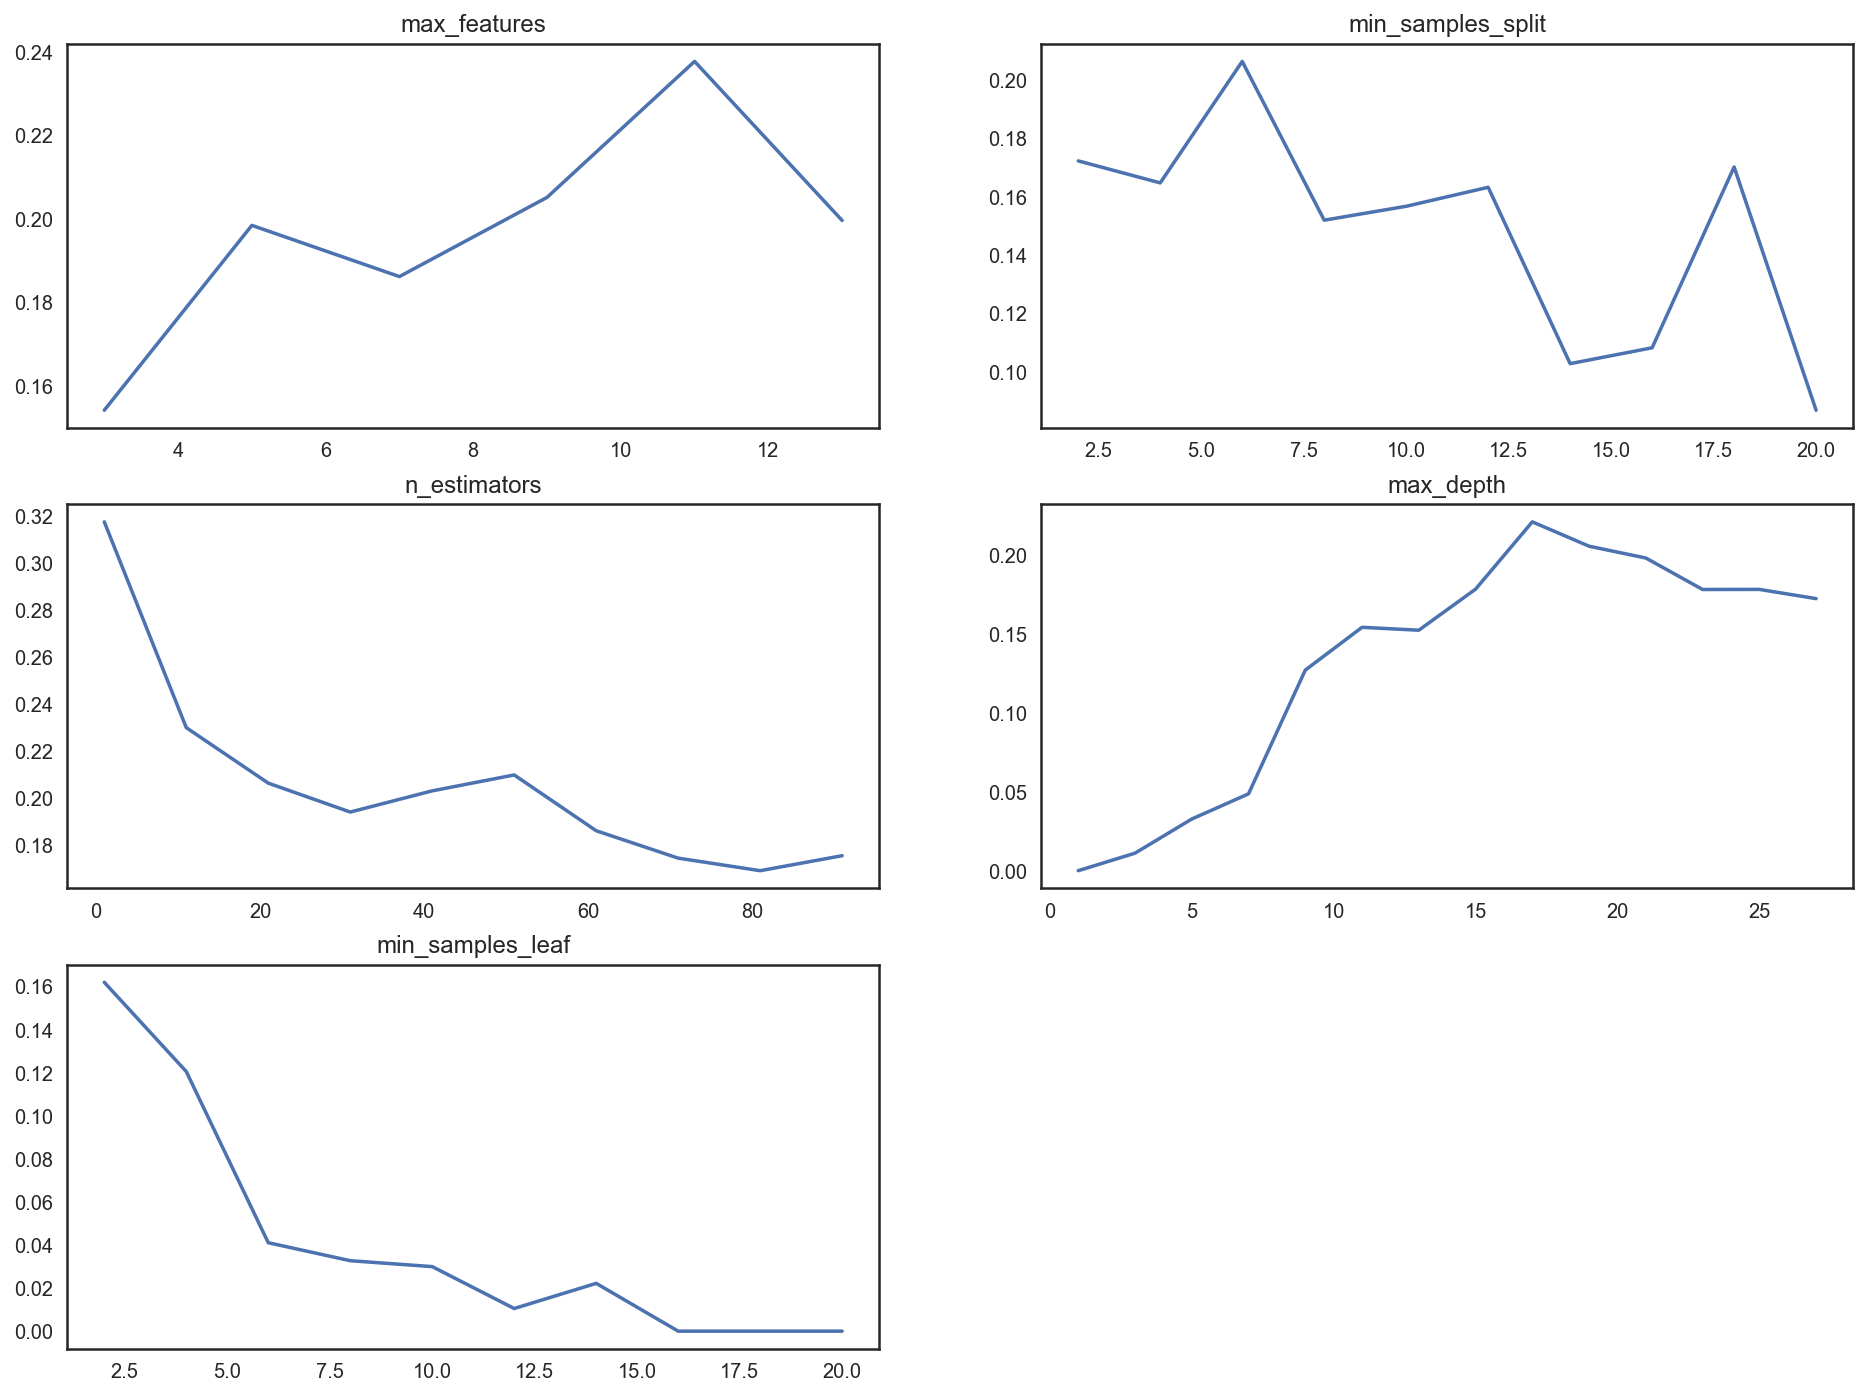

In [67]:
ExtC = RandomForestClassifier(n_jobs = njobs, random_state =rs, bootstrap=False, criterion="gini", class_weight=None)

ex_param_grid_1 = {"max_depth": np.arange(1, 28, 2),
                  "max_features": range(3,14,2),
                  "min_samples_split": range(2,22,2),
                  "min_samples_leaf": range(2,22,2),
                  "n_estimators" : np.arange(1, 100, 10),
                  }

grid_search_wrapper_loop(
    dataset, test_set, [2016], [2017], index_list, target_var_list, 
    'StandardScaler', [races[-1]], races, races_dict, ExtC, ex_param_grid_1, scorer='f1', refit=True,
    print_stats=False, plot_params=True
)

#### Param Grid 1

In [349]:
ExtC = ExtraTreesClassifier(n_jobs = njobs, random_state =rs, bootstrap=False, criterion="gini", class_weight=None,
                            min_samples_leaf=2, max_depth=None)

ex_param_grid = {
                 "max_depth": [6,8,10],
                 "max_features": [5,10,15],
                 "min_samples_split": [6,12,18],
                 "n_estimators" :[10,50]
                  }

In [350]:
extc_params = grid_search_wrapper_loop(
    dataset, test_set,  [2016], [2017], index_list, target_var_list, 
    'StandardScaler', races, races, races_dict, ExtC, ex_param_grid, scorer='f1', refit=True, print_stats=False, plot_params=False
)

### 3) Gradient Boosting Classifier

#### Param Grid 1

In [353]:
GBC = GradientBoostingClassifier(random_state =rs, min_samples_leaf=2, max_depth=None)

gb_param_grid = {
                 "max_features": [5,10,15],
                 "min_samples_split": [6,12,18],
                 "n_estimators" :[10,50]
                  }

In [354]:
gbc_params = grid_search_wrapper_loop(
    dataset, test_set, [2016], [2017], index_list, target_var_list, 
    'StandardScaler', races, races, races_dict, GBC, gb_param_grid, scorer='f1', refit=True, print_stats=False, plot_params=False
)

### 4) MLP

#### Param Grid 1

In [361]:
hidden_neurons = range(2,17,1)
hidden_layer_sizes1 = [(i,) for i in np.unique(hidden_neurons)]

In [362]:
MLP = MLPClassifier(random_state =rs)

mlp_param_grid  = {"solver": ['lbfgs'],
                   'hidden_layer_sizes': hidden_layer_sizes1,
                   'activation': ['logistic', 'relu']}

In [363]:
mlp_params = grid_search_wrapper_loop(
    dataset, test_set, [2016], [2017], index_list, target_var_list, 
    'StandardScaler', races, races, races_dict, MLP, mlp_param_grid, scorer='f1', refit=True, print_stats=False
)

### Transform list of classifiers to input to function that generates predictions

#### List 1: A total of 13 classifiers used per race.
First-level predictions from:
1. Trees Based Classifiers tuned with <b>Param Grid 1</b> (for each race) -> 3 X 3
2. MLP Classifier tuned with <b>Param Grid 1</b> -> 1 X 3
3. LDA -> 1

In [369]:
extc_params_list = pd.DataFrame(extc_params.groupby('name')['classifiers'].apply(list)).reset_index()
rfc_params_list = pd.DataFrame(rfc_params.groupby('name')['classifiers'].apply(list)).reset_index()
gbc_params_list = pd.DataFrame(gbc_params.groupby('name')['classifiers'].apply(list)).reset_index()
mlp_params_list = pd.DataFrame(mlp_params.groupby('name')['classifiers'].apply(list)).reset_index()

In [370]:
params_list_top3 = [extc_params_list.classifiers[i][0:3] + rfc_params_list.classifiers[i][0:3] + 
                    gbc_params_list.classifiers[i][0:3] + mlp_params_list.classifiers[i][0:3] + [LinearDiscriminantAnalysis()] 
                    for i,v in enumerate(extc_params_list.classifiers)]

tuned_cls_top3 = [[[str(x).split('Classifier')[0]+str(idx),x] if 'Classifier' in str(x) \
                         else [str(x).split('(')[0]+str(idx),x] for idx,x in enumerate(i)] for i in params_list_top3]

### Save all the tuned classifier objects 

In [90]:
import cPickle

# save the classifier
def save_classifier(var, filename):
    with open(directory + filename, 'wb') as fid:
        cPickle.dump(var, fid) 

#### 1. Classifiers tuned with 'Param Grid 1' (for each race)

In [379]:
save_classifier(tuned_cls_top3, 'tuned_cls_top3.pickle')
print("Total number of tuned classifiers to test per race:", len(tuned_cls_top3[0]))

('Total number of tuned classifiers to test per race:', 13)


In [380]:
tuned_clfs = pd.concat([extc_params, rfc_params, gbc_params, mlp_params])
tuned_clfs.to_pickle(os.path.join(directory,  "tuned_clfs.pickle"))

### Plot learning curves

In [133]:
def plot_learning_curve(axes, row, col, estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes[row,col].grid()
    
    axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[row,col].legend(loc="best")
    
    return 

In [167]:
def plot_learning_curve_loop(clfs_list, df, df_test, train_yr, test_yr, index_list, target_var_list, 
                             scaler, races_to_use, races_curr_same_cat, races_same_cat, skfold):
    
    nrows = len(clfs_list[0])
    ncols = len(races_to_use)

    cols = [i for i in races_to_use]
    rows = [i[0] for i in clfs_list[0]]

    fig, axes = plt.subplots(nrows, ncols, figsize=(15,60), sharex=True, sharey=True)

    for row in range(nrows):
        for col in range(ncols):
            
            train_set, test_set, Xs_train, Xs_test, Y_train, Y_test = \
              build_train_test_set(
                                df, df_test, train_yr, test_yr, 
                                index_list, target_var_list, target_var_list, scaler, 
                                races[col], races_curr_same_cat, races_same_cat, multilabel=False, print_stats=False)

            plot_learning_curve(axes, row, col, clfs_list[col][row][1],Xs_train,Y_train,cv=skfold)

    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90)

#### Plot for the first 3 races of the season

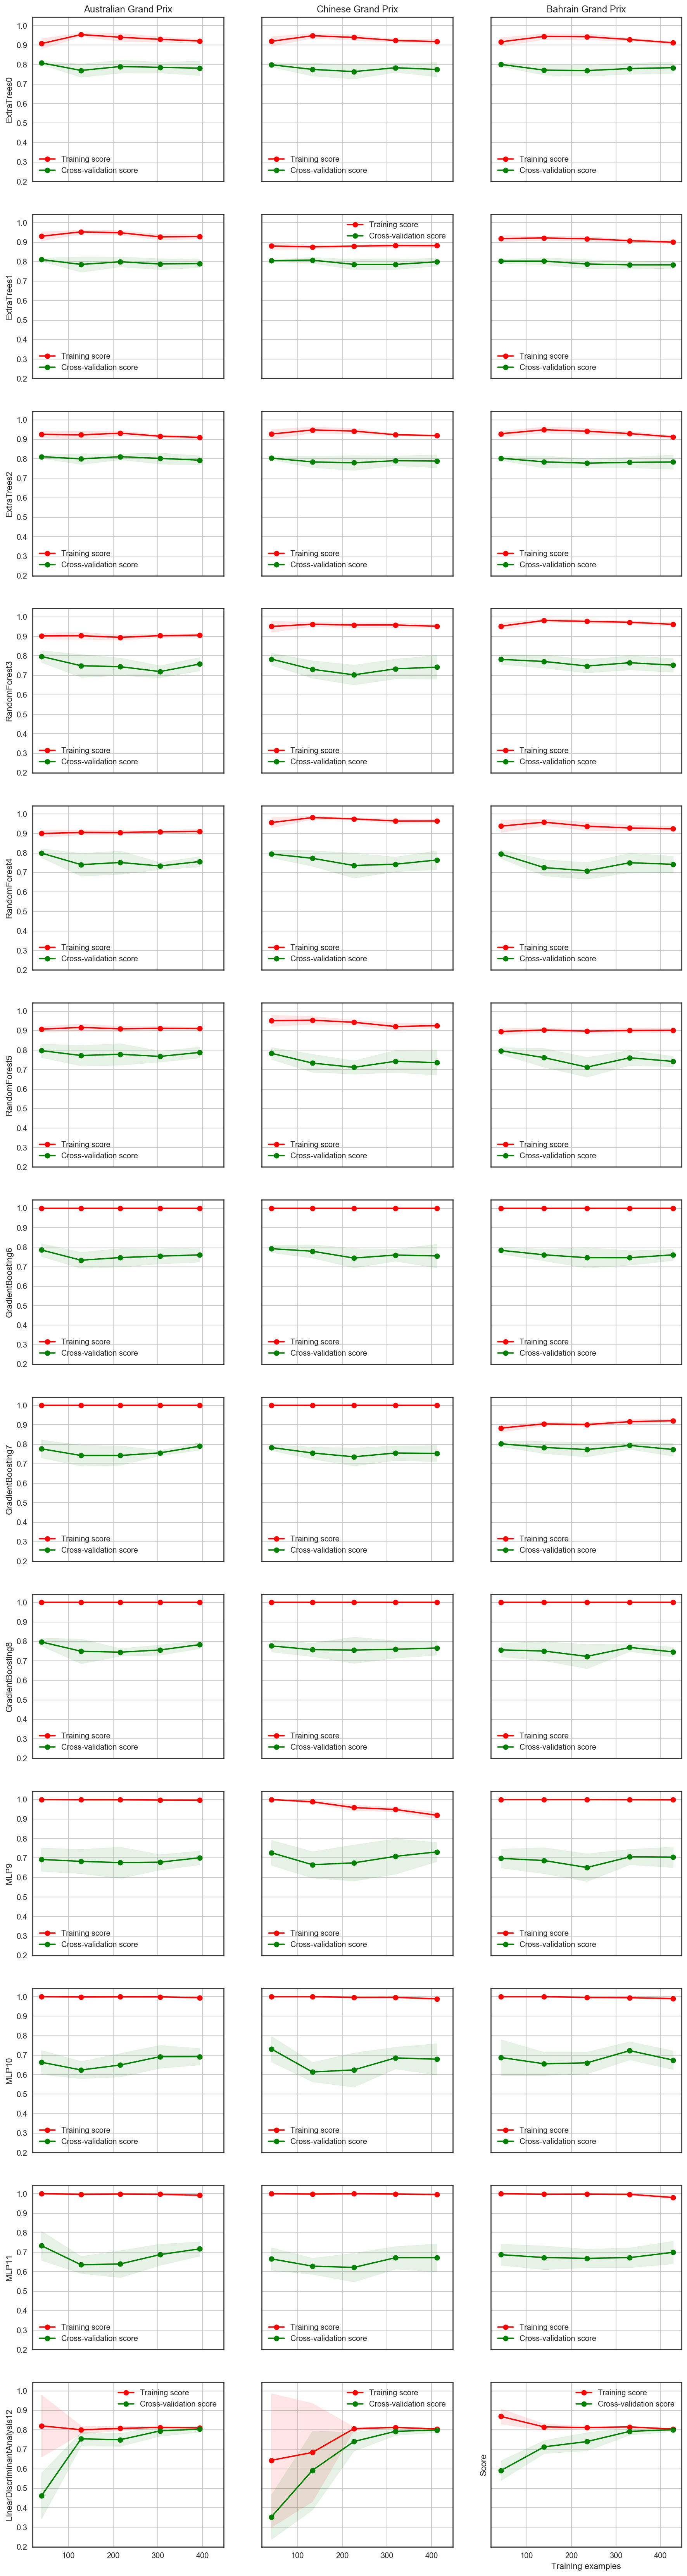

In [378]:
# Classifiers tuned based on Param Grid 1
    
plot_learning_curve_loop(tuned_cls_top3, dataset, test_set, [2016], [2017], index_list, target_var_list, 
                        'StandardScaler', races[0:3], races, races_dict, skfold)